# Estimation of collimation ratio 
This notebook uses a series of resolution measurements taken at different distances from the detector. Hence, there will be a blurring induced by the beam divergence.

The procedure is described in a paper published (in press) in Physics Procedia, Procedings of the ITMNR8, Beijing, 2016. DOI and full citation will appear here as soon as I have it. 

I kindly ask you to cite this paper if you use this notebook.

## Import some needed libraries

In [2]:
import numpy as np
import numpy.linalg.linalg as la
import matplotlib.pyplot as plt

%matplotlib inline 

## Define the model
The total observed blurring is the quadratic mean of the detector unsharpness (constant) and the penumbra blurring (depends on the distance from the detector). The function below implements this model to visualize the effect of different resolutions and collimation ratios.
It can also be used to test the performance of the model fitting.

$$\sigma_{total}=\sqrt{{\sigma_{Detector}}^2 + \left(\frac{d}{LD}\right)^2}$$

In [3]:
def PenumbraBlurringModel(distances, detectorresolution, collimation) :
    resolution = np.sqrt(detectorresolution**2 + (distances/collimation)**2)
    
    return resolution

## Demonstrate the model

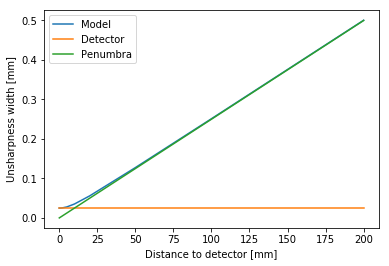

In [7]:
distances = np.array([0.05,1.0,2.0,5.0,10.0,20.0,50.0,100.0,200.0]) # [mm]
detectorresolution = 0.025 # [mm]
LD = 400

resolution = PenumbraBlurringModel(distances,detectorresolution,LD)

plt.plot(distances,resolution,
         distances,detectorresolution*np.ones(distances.size,),
         distances,distances/LD)
#plt.plot(distances,resolution)
plt.xlabel("Distance to detector [mm]")
plt.ylabel("Unsharpness width [mm]")
plt.legend(("Model","Detector","Penumbra"))
plt.savefig('unsharpness_LD400_res25um.png')

As you can see here, the model does not produce a straight line. What is happening is when you are close to the detector your detector resolution starts to dominate the blurring effect while on more remote observations are dominated by the penumbra blurring.

## An estimator to fit the blurring model
The model is fitted using a distance weighted least squares fit. The reason for doing this weighting is that we want the observations close to the detector to have higher impact on the fitting in order to capture the bent curve caused by the detector resolution.
$$H=\left[\begin{array}[cc] 
a 1 & d_1^2\\
\vdots &\vdots\\
1 & d_N^2
\end{array}\right]
\qquad 
C=diag\left(\left[\begin{array}[ccc]a d_1 & \cdots & d_N\end{array}\right]\right)
\qquad
y^T=\left[\begin{array}[ccc]a y_1^2 & \cdots & y_N^2\end{array}\right]
$$

$$\theta = (H^T\,C^{-1}H)^{-1}\,H^T\,C^{-1}\,y$$

In [5]:
def FitCollimationRatio(distance,resolution,weighted=True) :
    H=np.array((np.ones(distance.size,), np.transpose(distance**2)))
    H=np.transpose(H)
               
    r2 = np.transpose(resolution**2)   

    if (weighted==True) :
        C=la.inv(np.diag(distance))        
    else :
        C=np.diag(np.ones(distance.size,))
        
    CH=np.dot(C,H)
    HCy=np.dot(np.transpose(H),np.dot(C,np.transpose(r2)))
        
    theta=np.dot(la.inv(np.dot(np.transpose(H),CH)),HCy)
       
    return np.sqrt(theta[0]),1/np.sqrt(theta[1]),np.sqrt(np.dot(H,theta))

## Demonstration of the fit
Here we will use the parameters and blurring from the model above to test the model fitting.

LD = 500.0 , resolution = 0.1


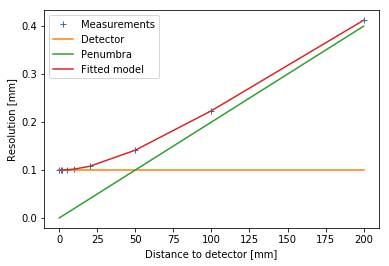

In [6]:
distances = np.array([0.05,1.0,2.0,5.0,10.0,20.0,50.0,100.0,200.0]) # [mm]
detectorresolution_true = 0.1 # [mm]
LD_true = 500

resolution = PenumbraBlurringModel(distances,detectorresolution_true,LD_true)

res,LD,fit = FitCollimationRatio(distances,resolution,True)
print("LD =",LD,", resolution =",res)
plt.plot(distances,resolution,'+',
         distances,res*np.ones(distances.size,),
         distances,distances/LD,
         distances,fit)
plt.xlabel("Distance to detector [mm]")
plt.ylabel("Resolution [mm]")
plt.legend(("Measurements","Detector","Penumbra","Fitted model"))

## Estimate with experiment data
Acquire the resolution with more points close to the detector, this is where most action takes place.

LD = 216.714344691 , resolution = 0.171515754188


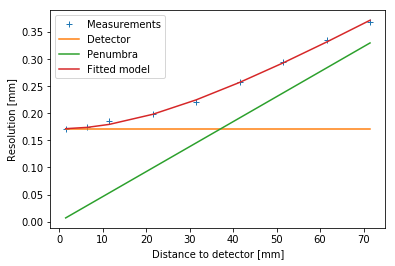

In [7]:
distances = np.array([1.5, 6.5,11.5,21.5, 31.5,41.5,51.5,61.5,71.5])  # Replace the values with the distances for your observations
res_observed  = np.array([170.8894,174.7753,184.9654,198.162,220.0241,257.8464,295.0429,334.9116,368.6509])  # Replace the values with the your resolution measurements
res_observed =res_observed/1000
# Run the estimator
res,LD,fit = FitCollimationRatio(distances,res_observed)

# Display the results
print("LD =",LD,", resolution =",res)
plt.plot(distances,res_observed,'+',
        distances,res*np.ones(distances.size,),
         distances,distances/LD,
         distances,fit)


plt.xlabel("Distance to detector [mm]")
plt.ylabel("Resolution [mm]") # adjust the label to quantity you measured
plt.legend(("Measurements","Detector","Penumbra","Fitted model"))

In [8]:
whos

Variable                  Type        Data/Info
-----------------------------------------------
FitCollimationRatio       function    <function FitCollimationRatio at 0x10618ebf8>
LD                        float64     216.714344691
LD_true                   int         500
PenumbraBlurringModel     function    <function PenumbraBlurringModel at 0x10618e510>
detectorresolution        float       0.17
detectorresolution_true   float       0.1
distances                 ndarray     9: 9 elems, type `float64`, 72 bytes
fit                       ndarray     9: 9 elems, type `float64`, 72 bytes
la                        module      <module 'numpy.linalg.lin<...>/numpy/linalg/linalg.py'>
np                        module      <module 'numpy' from '/Us<...>kages/numpy/__init__.py'>
plt                       module      <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
res                       float64     0.171515754188
res_observed              ndarray     9: 9 elems, type `float64`, 72 b

LD = 924.927107636 , resolution = 0.109654948811


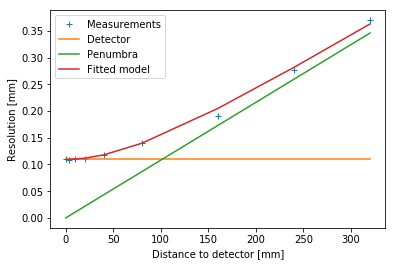

In [21]:
d=np.array([2,12 ,22 ,42 , 82, 162,242,322 ])
w=np.array([0.109655, 0.108396, 0.110992, 0.109315, 0.117368,  0.140944,0.191246,0.275928,0.369836])

res,LD,fit = FitCollimationRatio(d,w)

# Display the results
print("LD =",LD,", resolution =",res)
plt.plot(d,w,'+',
        d,res*np.ones(distances.size,),
         d,d/LD,
         d,fit)


plt.xlabel("Distance to detector [mm]")
plt.ylabel("Resolution [mm]") # adjust the label to quantity you measured
plt.legend(("Measurements","Detector","Penumbra","Fitted model"))